In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

+ Marginal distribution of each data point:**

\begin{equation*}
\mathbf{x}_n \sim \mathcal{N}(\mathbf{0}, \mathbf{W} \mathbf{W}^T + \sigma^2 \mathbf{I})
\end{equation*}

+ Create a model as follow:
    * $\mathbf{z}_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
    * $\mathbf{W} \sim \mathcal{N}(\mathbf{0}, 2 \mathbf{I})$
    * $\mathbf{x}_n | \mathbf{z}_n \sim \mathcal{N}(
        \mathbf{W} \mathbf{z}_n, \sigma^2 \mathbf{T} 
      )$


In [34]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddev_datapoints):
    w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                  scale=2.0 * tf.ones([data_dim, latent_dim]),
                  name="w") # parameter
    z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                  scale=tf.ones([latent_dim, num_datapoints]),
                  name="z") # parameter
    x = ed.Normal(loc=tf.matmul(w, z),
                  scale=stddev_datapoints * tf.ones([data_dim, num_datapoints]),
                  name="x") # modeled (observed) data
    return x, (w, z)

log_joint = ed.make_log_joint_fn(ppca_model)

### GENERATE DATASET

In [37]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddev_datapoints = 0.5

model = ppca_model(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddev_datapoints=stddev_datapoints)

with tf.Session() as sess:
    x_train, (actual_w, actual_z) = sess.run(model)
    
print("Principal axes: ")
print(actual_w)

Principal axes: 
[[ 0.52401525]
 [-3.7824962 ]]


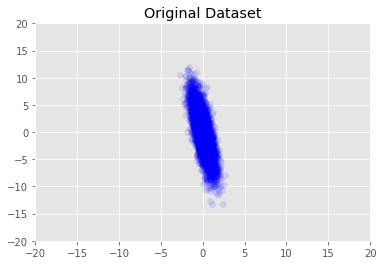

In [38]:
plt.scatter(x_train[0,:], x_train[1,:], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Original Dataset")
plt.plot(actual_z)
plt.show()

### MAP: Maximum A Posterior Inference

+ **Goal**: find the point estimate of laten variables that maximizes the posterior probability density (maximum a posterior inference).
+ **Note**: The point-estimate methods find the exact values for each latent var. The variational methods find the probability distribution of the value of each latent var.
+ **How**: Calculating the values of $\mathbf{W}$ and $\mathbf{Z}$ that maxmize the posterior density: $p(\mathbf{W}, \mathbf{Z} | \mathbf{X})\propto p(\mathbf{W}, \mathbf{Z}, \mathbf{X})$.
Note that the `log_joint` function created by `ed.make_log_joint_fn` will represent for the log of the joint distribution of all variables in the model.

In [38]:
# what we actually want to find is `w` and `z`
# we have had their asumption "prior" values.
# we need to use the observed data `x` to do inference:
# that means, to transfer the prior to the posterior
# and the final expected results will be in `w_inferred_map` and `z_inferred_map`

In [39]:
# first, define `w` and `z` as variable in the model

tf.reset_default_graph()

w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

In [40]:
# second, define a target function, which is an "unnormalized target density".
# as a function of the parameters `w`, `z`
# Note that we want to maximize the posterior distr.
# which is proportional to the joint distribution of the model
# -> the target function to maximize is exactly the joint distr. function
def target(w, z):
    return log_joint(data_dim=data_dim,
              latent_dim=latent_dim,
              num_datapoints=num_datapoints,
              stddev_datapoints=stddev_datapoints,
              w=w, z=z, x=x_train)

In [41]:
# third, define the "energy function", which is the opposite of target function
# we will use the off-the-shelf optimization module which minimize an objective function
# that's why we conver the maximization prob. to mizimization one
energy = - target(w, z)

optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
train = optimizer.minimize(energy)

In [42]:
# Learning params === Infering

init = tf.global_variables_initializer()

t = []

num_epochs = 200

with tf.Session() as sess:
    # init all variables
    sess.run(init)
    
    # start to train
    for i in range(num_epochs):
        sess.run(train)
        
        if i % 5 == 0:
            # get snapshot of the current values of function and vars
            cE, cw, cz = sess.run([energy, w, z])
            t.append(cE)
    
    # when finishing the training, get the learned values of the variables
    w_inferred_map = sess.run(w)
    z_inferred_map = sess.run(z)

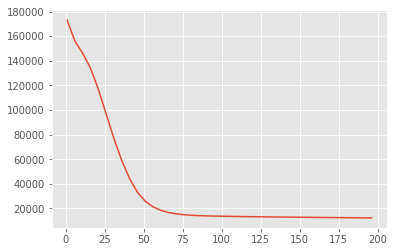

In [43]:
x = range(1, num_epochs, 5)
plt.plot(x, t)
plt.show()

In [44]:
print("Principal axes: ")
print(actual_w)

print("MAP estimated axes:")
print(w_inferred_map)

Principal axes: 
[[ 0.52401525]
 [-3.7824962 ]]
MAP estimated axes:
[[-0.48563898]
 [ 3.4344344 ]]


### Model criticism

In [45]:
# using Edward2 model to sample data from inferred values of W and Z

def replace_latents(w=actual_w, z=actual_z):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replace the prior with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "w":
            rv_kwargs["value"] = w
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)
    
    return interceptor


with ed.interception(replace_latents(w_inferred_map, z_inferred_map)):
    generative_process = ppca_model(
        data_dim=data_dim, latent_dim=latent_dim,
        num_datapoints=num_datapoints, stddev_datapoints=stddev_datapoints
    )
    
with tf.Session() as sess:
    x_generated, _ = sess.run(generative_process)

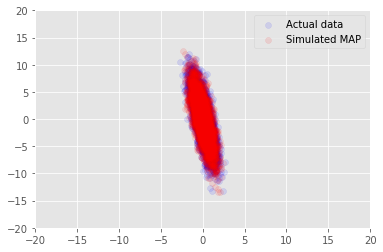

In [46]:
# compare the actual data with the simulated data 
# which is generated from the joint model with the MAP estimated `w` and `z`

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated MAP')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()